In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [ ]:
df = pd.read_csv('minimal_merlin_data.csv') 

In [ ]:
df = df.replace({True: 1, False: 0})

In [46]:
# Filter the DataFrame to include only neuraxial catheter (ie, epidural + CSE + intrathecal) or epidural-only catheter procedures
neuraxial_catheter_df = df[df['is_neuraxial_catheter'] == 1]
epidural_df = df[(df['true_procedure_type'] == 'epidural')]

# Describe Dataframe

There are 158364 total rows, of which 22218 have NaN true_procedure_type.

Every row receives a value for all Boolean variables: thus if no value is present, they become False. Furthermore, NaN procedures become False is_neuraxial_catheter and failed_catheter.

is_neuraxial_catheter includes epidurals + CSEs + intrathecals

failed_catheter is applied to BOTH neuraxial_catheters (which may be coded True or False for failure) and also to all procedures that are not neuraxial_catheters (will always be coded False).

In [ ]:
df.shape

In [ ]:
def describe_dataframe(df):
    """
    For each column in df:
      - If dtype is object or int64 or bool, list each unique value and its counts.
      - If dtype is float64, display min, Q1, median, Q3, and max.
      - Otherwise, handle accordingly (datetime, etc.).
    """
    for col in df.columns:
        col_type = df[col].dtype

        print(f"Column: {col}")
        print(f"  Data Type: {col_type}")

        if col_type == 'object' or col_type == 'int64' or col_type == 'bool':
            # Show unique values and their counts
            value_counts = df[col].value_counts(dropna=False)
            print("  Value counts:")
            for val, count in value_counts.items():
                print(f"    {val}: {count}")

        elif col_type == 'float64':
            # Show min, Q1 (25%), median (50%), Q3 (75%), and max
            desc = df[col].describe(percentiles=[0.25, 0.5, 0.75])
            na_count = df[col].isna().sum()
            print("  Summary stats:")
            print(f"    NaN:    {na_count}")
            print(f"    Min:    {desc['min']}")
            print(f"    Q1:     {desc['25%']}")
            print(f"    Median: {desc['50%']}")
            print(f"    Q3:     {desc['75%']}")
            print(f"    Max:    {desc['max']}")

        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            # Example handling for datetime columns
            print("  (Datetime column – no numeric summary or value counts shown.)")

        else:
            # Handle any other data types as needed
            print("  (No specific handling implemented for this data type.)")

        print("-" * 50)

describe_dataframe(df)


In [49]:
def describe_as_tables(df):
    # Separate columns by dtype
    categorical_cols = []
    numeric_cols = []

    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'int64' or df[col].dtype == 'bool':
            categorical_cols.append(col)
        elif df[col].dtype == 'float64':
            numeric_cols.append(col)
        else:
            # skip or handle datetime, etc. if desired
            pass

    # --- Build table for categorical variables ---
    cat_data = {}
    for col in categorical_cols:
        # Get value counts (including NaN as a separate category)
        vc = df[col].value_counts(dropna=False)
        # Convert value counts to a dict, or a formatted string
        vc_str = ", ".join(f"{val}: {count}" for val, count in vc.items())
        cat_data[col] = {
            'value_counts': vc_str
        }
    cat_df = pd.DataFrame(cat_data).T  # Transpose so rows = columns, col = 'value_counts'

    # --- Build table for numeric variables ---
    num_data = {}
    for col in numeric_cols:
        desc = df[col].describe(percentiles=[0.25, 0.5, 0.75])
        na_count = df[col].isna().sum()
        num_data[col] = {
            'count': desc['count'],
            'count_nan': na_count,
            'min': desc['min'],
            'Q1': desc['25%'],
            'median': desc['50%'],
            'Q3': desc['75%'],
            'max': desc['max']
        }
    num_df = pd.DataFrame(num_data).T  # Transpose so rows = columns

    return cat_df, num_df

cat_table, num_table = describe_as_tables(df)


In [ ]:
cat_table

In [ ]:
num_table

# Data Visualization

## Procedure Types

In [ ]:
# prompt: make a histogram of procedure note types using different colors

# Assuming 'procedure_type' column exists in your DataFrame 'df'
procedure_type_counts = df['true_procedure_type'].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(procedure_type_counts.index, procedure_type_counts.values, color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange'])
plt.xlabel('Procedure Type')
plt.ylabel('Count')
plt.title('Histogram of Procedure Note Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of successes/failures

# Group by procedure type and whether it has subsequent anesthesia
procedure_counts = pd.crosstab(neuraxial_catheter_df['true_procedure_type'], neuraxial_catheter_df['failed_catheter'])

# Sort the bars in descending order based on the total count of each procedure type
procedure_counts = procedure_counts.sort_values(by=0, ascending=False)

# Create a stacked bar chart
ax = procedure_counts.plot(kind='bar', stacked=True, figsize=(6
, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
  width = p.get_width()
  height = p.get_height()
  x, y = p.get_xy()
  ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Procedure Type')
plt.ylabel('Count')
plt.title('Histogram of Successful/Failed')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()


In [ ]:
# Display the table with the same information
print("Table of Neuraxial Catheter Procedures by Success/Failure:")
print(procedure_counts)


## Anesthesiologist Experience

In [ ]:
# prompt: Create a similar histogram for failure rate vs highly experienced anesthesiologist

# Group by 'highly_experienced_anesthesiologist' and 'failed_catheter'
experience_failure_counts = pd.crosstab(neuraxial_catheter_df['highly_experienced_anesthesiologist'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = experience_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Anesthesiologist Experience')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Anesthesiologist Experience')
plt.xticks(rotation=0, ha='center', ticks=[0,1,2], labels=['No Anesthesiologist','Not Highly Experienced', 'Highly Experienced'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Anesthesiologist Experience:")
experience_failure_counts

In [ ]:
# prompt: create a similar histogram for failure rate vs moderately experienced anesthesiologist

# Group by 'moderately_experienced_anesthesiologist' and 'failed_catheter'
experience_failure_counts = pd.crosstab(neuraxial_catheter_df['moderately_experienced_anesthesiologist'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = experience_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Anesthesiologist Experience')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Moderately Experienced Anesthesiologist')
plt.xticks(rotation=0, ha='center', ticks=[0,1,2], labels=['No Anesthesiologist','Not Moderately Experienced', 'Moderately Experienced'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Moderately Experienced Anesthesiologist:")
experience_failure_counts

In [ ]:
# prompt: Create a similar histogram for failure rate vs highly experienced resident

# Group by 'highly_experienced_resident' and 'failed_catheter'
experience_failure_counts = pd.crosstab(neuraxial_catheter_df['highly_experienced_resident'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = experience_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Resident Experience')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Resident Experience')
plt.xticks(rotation=0, ha='center', ticks=[0,1,2], labels=['No Resident','Not Highly Experienced', 'Highly Experienced'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Resident Experience:")
experience_failure_counts

In [ ]:
# prompt: Create a similar histogram but look at all combinations of resident and anesthesiologist experience. Make the x-axis labels vertical.

# Group by 'highly_experienced_anesthesiologist', 'highly_experienced_resident', and 'failed_catheter'
experience_failure_counts = pd.crosstab([neuraxial_catheter_df['highly_experienced_anesthesiologist'], neuraxial_catheter_df['highly_experienced_resident']], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = experience_failure_counts.plot(kind='bar', stacked=True, figsize=(8, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Anesthesiologist and Resident Experience')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Anesthesiologist and Resident Experience')


# Customize x-axis labels
import itertools
anesth_levels = ["Anes=None", "Anes=Not Exp", "Anes=Exp"]
resident_levels = ["Res=None", "Res=Not Exp", "Res=Exp"]
labels = list(itertools.product(anesth_levels, resident_levels))
plt.xticks(rotation=90, ha='center', ticks=range(len(labels)), labels=labels)

plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Anesthesiologist and Resident Experience:")
experience_failure_counts

In [ ]:
# prompt: crosstab resident experience by BMI and make violin plots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame (as defined in the provided code)
# and it contains columns 'bmi_end_pregnancy_2044' and 'resident_experience' (or a similar column)

# Create the cross-tabulation
crosstab_data = pd.crosstab(neuraxial_catheter_df['bmi_end_pregnancy_2044'], neuraxial_catheter_df['highly_experienced_resident'])

# Display the cross-tabulation
print("Crosstab of Resident Experience by BMI:")
print(crosstab_data)

# Create violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x='highly_experienced_resident', y='bmi_end_pregnancy_2044', data=df)
plt.xlabel('Resident Experience')  # Customize the x-axis label
plt.ylabel('BMI') # Customize the y-axis label
plt.title('Violin Plot of BMI by Resident Experience')
plt.show()

## Delivery Site

In [ ]:
# prompt: create a similar histogram of delivery_site_2188 using crosstab

# Create a crosstab for 'delivery_site_2188' and visualize it as a histogram
delivery_site_counts = pd.crosstab(neuraxial_catheter_df['delivery_site_2188'], neuraxial_catheter_df['failed_catheter'])

# Sort the bars in descending order based on the total count of each delivery site
delivery_site_counts = delivery_site_counts.sort_values(by=0, ascending=False)

# Create a stacked bar chart
ax = delivery_site_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Delivery Site')
plt.ylabel('Count')
plt.title('Histogram of Delivery Site by Success/Failure')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Delivery Site by Success/Failure:")
delivery_site_counts

## DPE

In [ ]:
# prompt: # prompt: create a pie chart of the fraction of DPE in epidural_df

# Count DPE values, treating NaN and '' as "no"
dpe_counts = epidural_df['dpe'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(dpe_counts, labels=dpe_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Fraction of DPE in Epidural Procedures')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# prompt: reproduce the above histogram using crosstab on delivery_site_2188 and dpe

# Assuming 'df' is your DataFrame (as defined in the provided code)

# Create a crosstab for 'delivery_site_2188' and 'dpe' and visualize it as a histogram
delivery_site_dpe_counts = pd.crosstab(epidural_df['delivery_site_2188'], epidural_df['dpe'])

# Sort the bars in descending order based on the total count of each delivery site
delivery_site_dpe_counts = delivery_site_dpe_counts.sort_values(by=1, ascending=False) # Sort by 'no'

# Create a stacked bar chart
ax = delivery_site_dpe_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Delivery Site')
plt.ylabel('Count')
plt.title('Histogram of Delivery Site by DPE')
plt.xticks(rotation=45, ha='right')
plt.legend(['DPE: no', 'DPE: yes']) # Update legend labels
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Delivery Site by DPE:")
delivery_site_dpe_counts

In [ ]:
# Histogram of successes/failures by DPE status

# Group by procedure type and whether it has subsequent anesthesia
dpe_crosstab = pd.crosstab(epidural_df['dpe'], epidural_df['failed_catheter'])

# Create a stacked bar chart
ax = dpe_crosstab.plot(kind='bar', stacked=True, figsize=(6
, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
  width = p.get_width()
  height = p.get_height()
  x, y = p.get_xy()
  ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('DPE Status')
plt.ylabel('Count')
plt.title('Histogram of Successful/Failed')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()


In [ ]:
# prompt: do a crosstab histogram of failure versus delivery_site_2188 and dpe

# Assuming 'df' is your DataFrame (as defined in the provided code)

# Create a crosstab for 'delivery_site_2188', 'dpe', and 'failed_catheter'
crosstab_df = pd.crosstab([df['delivery_site_2188'], df['dpe']], df['failed_catheter'])

# Create a stacked bar chart
ax = crosstab_df.plot(kind='bar', stacked=True, figsize=(12, 6))

# Annotate the bars with percentages
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')


plt.xlabel('Delivery Site and DPE')
plt.ylabel('Count')
plt.title('Crosstab Histogram: Failure vs. Delivery Site and DPE')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the crosstab table
print("Crosstab Table:")
crosstab_df

## Scoliosis and back problems

In [ ]:
# prompt: create a histogram of the crosstab of has_scoliosis vs failure_rate

# Assuming 'neuraxial_catheter_df' is your DataFrame (as defined in the provided code)

# Group by 'has_scoliosis' and 'failed_catheter'
scoliosis_failure_counts = pd.crosstab(neuraxial_catheter_df['has_scoliosis'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = scoliosis_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Has Scoliosis')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Scoliosis')
plt.xticks(rotation=0, ha='center', ticks=[0, 1], labels=['No Scoliosis', 'Scoliosis'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Scoliosis:")
scoliosis_failure_counts

In [ ]:
# prompt: do the same but for has_back_problems

# Group by 'has_back_problems' and 'failed_catheter'
back_problems_failure_counts = pd.crosstab(neuraxial_catheter_df['has_back_problems'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = back_problems_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Has Back Problems')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Back Problems')
plt.xticks(rotation=0, ha='center', ticks=[0, 1], labels=['No Back Problems', 'Back Problems'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Back Problems:")
back_problems_failure_counts

In [ ]:
# prompt: do the same but for has_dorsalgia

# Group by 'has_dorsalgia' and 'failed_catheter'
back_pain_failure_counts = pd.crosstab(neuraxial_catheter_df['has_dorsalgia'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = back_pain_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Has Back Pain')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Back Pain')
plt.xticks(rotation=0, ha='center', ticks=[0, 1], labels=['No Back Pain', 'Back Pain'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Back Pain:")
back_pain_failure_counts

## Fetal Presentation

In [ ]:
# prompt: do the same histogram, but for fetal_presentation_category vs failure

# Group by 'fetal_presentation_category_2243' and 'failed_catheter'
fetal_presentation_failure_counts = pd.crosstab(neuraxial_catheter_df['fetal_presentation_category_2243'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = fetal_presentation_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Fetal Presentation Category')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Fetal Presentation Category')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Fetal Presentation Category:")
fetal_presentation_failure_counts

In [ ]:
# prompt: do the same histogram, but for fetal_presentation_position vs failure

# Assuming 'neuraxial_catheter_df' is your DataFrame (as defined in the provided code)

# Group by 'fetal_presentation_position_2247' and 'failed_catheter'
fetal_position_failure_counts = pd.crosstab(neuraxial_catheter_df['fetal_presentation_position_2247'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = fetal_position_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Fetal Presentation Position')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Fetal Presentation Position')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Fetal Presentation Position:")
fetal_position_failure_counts

## Race and SES

In [ ]:
# prompt: do the same histogram, but for maternal_race vs failure

# Group by 'maternal_race' and 'failed_catheter'
race_failure_counts = pd.crosstab(neuraxial_catheter_df['maternal_race'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = race_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Maternal Race')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Maternal Race')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Maternal Race:")
race_failure_counts

In [ ]:
# prompt: do the same histogram, but for each of these: 32. composite_psychosocial_problems ||| int64
# 33. any_public_insurance ||| int64
# 34. maternal_language_english ||| int64
# 35. marital_status_married_or_partner ||| int64
# 36. country_of_origin_USA ||| int64
# 37. employment_status_fulltime ||| int64

# Assuming 'neuraxial_catheter_df' is your DataFrame

columns_to_analyze = [
    'composite_psychosocial_problems',
    'any_public_insurance',
    'maternal_language_english',
    'marital_status_married_or_partner',
    'country_of_origin_USA',
    'employment_status_fulltime'
]

for column in columns_to_analyze:
  # Group by the current column and 'failed_catheter'
  failure_counts = pd.crosstab(neuraxial_catheter_df[column], neuraxial_catheter_df['failed_catheter'])

  # Create a stacked bar chart
  ax = failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

  # Add percentages within each bar
  for p in ax.patches:
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

  plt.xlabel(column)
  plt.ylabel('Count')
  plt.title(f'Histogram of Failure Rate vs. {column}')

  # Customize x-axis ticks and labels (adjust as needed for each column)
  plt.xticks(rotation=0, ha='center')

  plt.legend(['Successful', 'Failed'])
  plt.tight_layout()
  plt.show()

  # Display the table with the same information
  print(f"Table of Failure Rate vs. {column}:")
failure_counts

## Pain

In [ ]:
# prompt: do the same histogram but for prior_pain_scores_max

# Assuming 'neuraxial_catheter_df' is your DataFrame

# Group by 'prior_pain_scores_max' and 'failed_catheter'
prior_pain_failure_counts = pd.crosstab(neuraxial_catheter_df['prior_pain_scores_max'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = prior_pain_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Prior Pain Scores Max')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Prior Pain Scores Max')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Prior Pain Scores Max:")
prior_pain_failure_counts

## Gravidity and Parity

In [ ]:
# prompt: do the same histogram but for gravidity_2047 and parity_2048

# Assuming 'neuraxial_catheter_df' is your DataFrame

# Group by 'gravidity_2047' and 'failed_catheter'
gravidity_failure_counts = pd.crosstab(neuraxial_catheter_df['gravidity_2047'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = gravidity_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Gravidity')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Gravidity')
plt.xticks(rotation=0)  # Adjust rotation if needed
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table
print("Table of Failure Rate vs. Gravidity:")
print(gravidity_failure_counts)


# Group by 'parity_2048' and 'failed_catheter'
parity_failure_counts = pd.crosstab(neuraxial_catheter_df['parity_2048'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = parity_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Parity')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Parity')
plt.xticks(rotation=0)  # Adjust rotation if needed
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table
print("Table of Failure Rate vs. Parity:")
parity_failure_counts

## BMI / height / weight

In [ ]:
# prompt: plot bmi end pregnancy against failure rate using binning as above.

# Assuming 'bmi_end_pregnancy' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['bmi_end_pregnancy_2044', 'failed_catheter'])

# Bin the bmi_end_pregnancy
df_plot['bmi_end_pregnancy_bin'] = (df_plot['bmi_end_pregnancy_2044'] // 1).astype(int)

# Group by the binned bmi_end_pregnancy and calculate the mean and standard error of the mean of failed_catheter
failure_by_bmi = df_plot.groupby('bmi_end_pregnancy_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_bmi.index, failure_by_bmi['mean'], marker='o')
plt.fill_between(failure_by_bmi.index,
                 failure_by_bmi['mean'] - failure_by_bmi['sem'],
                 failure_by_bmi['mean'] + failure_by_bmi['sem'],
                 alpha=0.5) # Add shaded error bars

plt.xlabel('BMI (kg/m^2) at End of Pregnancy (binned by 1)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. BMI at End of Pregnancy (binned by 1) with Error Bars')
plt.grid(True)
plt.show()

In [ ]:
# prompt: # prompt: plot weight end pregnancy against failure rate using binning as above.

# Assuming 'maternal_weight_end_pregnancy_2045' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['maternal_weight_end_pregnancy_2045', 'failed_catheter'])

# Bin the maternal weight at the end of pregnancy
df_plot['weight_end_pregnancy_bin'] = (df_plot['maternal_weight_end_pregnancy_2045'] // 10).astype(int) * 10

# Group by the binned weight and calculate the mean and standard error of the mean of failed_catheter
failure_by_weight = df_plot.groupby('weight_end_pregnancy_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_weight.index, failure_by_weight['mean'], marker='o')
plt.fill_between(failure_by_weight.index,
                 failure_by_weight['mean'] - failure_by_weight['sem'],
                 failure_by_weight['mean'] + failure_by_weight['sem'],
                 alpha=0.5)  # Add shaded error bars

plt.xlabel('Maternal Weight (kg) at End of Pregnancy (binned by 10)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Maternal Weight at End of Pregnancy (binned by 10) with Error Bars')
plt.grid(True)
plt.show()

In [ ]:
# prompt: do the same but for height

# Assuming 'height' is a column in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['maternal_height_2046', 'failed_catheter'])

# Drop heights greater than 250
df_plot = df_plot[df_plot['maternal_height_2046'] <= 250]

# Bin the height
df_plot['height_bin'] = (df_plot['maternal_height_2046'] // 1).astype(int)

# Group by the binned height and calculate the mean and standard error of the mean of failed_catheter
failure_by_height = df_plot.groupby('height_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_height.index, failure_by_height['mean'], marker='o')
plt.fill_between(failure_by_height.index,
                 failure_by_height['mean'] - failure_by_height['sem'],
                 failure_by_height['mean'] + failure_by_height['sem'],
                 alpha=0.5) # Add shaded error bars

plt.xlabel('Height (binned by 1)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Height (binned by 1) with Error Bars')
plt.grid(True)
plt.show()

## Needle Type

In [ ]:
# prompt: do the same histogram but for epidural_needle_type

# Assuming 'epidural_df' is your DataFrame (as defined in the provided code)

# Group by 'epidural_needle_type' and 'failed_catheter'
needle_type_failure_counts = pd.crosstab(epidural_df['epidural_needle_type'], epidural_df['failed_catheter'])

# Create a stacked bar chart
ax = needle_type_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Epidural Needle Type')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Epidural Needle Type')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Epidural Needle Type:")
needle_type_failure_counts

## Paresthesias

In [ ]:
# prompt: do the same histogram but for paresthesias_present

# Group by 'paresthesias_present' and 'failed_catheter'
paresthesias_failure_counts = pd.crosstab(neuraxial_catheter_df['paresthesias_present'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = paresthesias_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Paresthesias Present')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Paresthesias Present')
plt.xticks(rotation=0, ha='center', ticks=[0, 1], labels=['No Paresthesias', 'Paresthesias'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Paresthesias Present:")
paresthesias_failure_counts

## Number of Attempts

In [ ]:
# prompt: create a histogram of the number of attempts. Only show integers on the x-axis

# Assuming 'number_of_neuraxial_attempts' is a column in your DataFrame 'df'
attempts_counts = df['number_of_neuraxial_attempts'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(attempts_counts.index, attempts_counts.values)
plt.xlabel('Number of Attempts')
plt.ylabel('Count')
plt.title('Histogram of Number of Neuraxial Attempts')
plt.xticks(range(int(attempts_counts.index.min()), int(attempts_counts.index.max()) + 1))  # Show only integer ticks on x-axis
plt.tight_layout()
plt.show()


## Loss of Resistance Depth

In [ ]:
# prompt: create a histogram of loss of resistance depth. Center the bars over the tick marks and make space between the bars. Bins should be every 0.5

# Assuming 'lor_depth' is a column in your DataFrame 'df'
lor_depths = neuraxial_catheter_df['lor_depth'].dropna()  # Remove NaN values

# Create the histogram with centered bars and spacing
plt.figure(figsize=(8, 6))
plt.hist(lor_depths, bins=np.arange(lor_depths.min(), lor_depths.max() + 0.5, 0.5), rwidth=0.8, align='left')
plt.xlabel('Loss of Resistance Depth')
plt.ylabel('Count')
plt.title('Histogram of Loss of Resistance Depth')
plt.xticks(np.arange(0, lor_depths.max() + 0.5, 1))  # Set x-axis ticks to be at every 1
plt.tight_layout()
plt.show()


In [ ]:
# prompt: Plot number of neuraxial attempts vs LOR depth on the x-axis. Add jiggle to both x and y axes

df_plot = neuraxial_catheter_df.dropna(subset=['number_of_neuraxial_attempts', 'lor_depth'])

# Add random jiggle to both x and y axes
jiggle_x = np.random.normal(scale = 0.1, size=len(df_plot))
jiggle_y = np.random.normal(scale = 0.1, size=len(df_plot))

plt.figure(figsize=(10, 6))
plt.scatter(df_plot['lor_depth'] + jiggle_x, df_plot['number_of_neuraxial_attempts'] + jiggle_y, alpha=0.5)
plt.xlabel('LOR Depth')
plt.ylabel('Number of Neuraxial Attempts')
plt.title('Number of Neuraxial Attempts vs. LOR Depth with Jiggle')
plt.show()


In [ ]:
# prompt: do the same but add shaded error bars for +/- standard error of the mean

# Assuming 'number_of_neuraxial_attempts' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['number_of_neuraxial_attempts'])

# Group by number of attempts and calculate the mean and standard error of the mean of failed_catheter
failure_by_attempts = df_plot.groupby('number_of_neuraxial_attempts')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot with error bars
plt.figure(figsize=(10, 6))
plt.plot(failure_by_attempts.index, failure_by_attempts['mean'], marker='o')
plt.fill_between(failure_by_attempts.index,
                 failure_by_attempts['mean'] - failure_by_attempts['sem'],
                 failure_by_attempts['mean'] + failure_by_attempts['sem'],
                 alpha=0.2) # Add shaded error bars
plt.errorbar(failure_by_attempts.index, failure_by_attempts['mean'], yerr=failure_by_attempts['sem'], fmt='o-', capsize=5, elinewidth=1)  # Added error bars
plt.xlabel('Number of Neuraxial Attempts')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Number of Neuraxial Attempts with Error Bars')
plt.xticks(np.arange(0, failure_by_attempts['number_of_neuraxial_attempts'].max() + 0.5, 1))  # Set x-axis ticks to be at every 0.5
plt.grid(True)
plt.show()

In [ ]:
# prompt: Plot lor-depth against bmi

# Assuming 'lor_depth' and 'bmi_end_pregnancy_2044' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'bmi_end_pregnancy_2044'])

plt.figure(figsize=(10, 6))
plt.scatter(df_plot['bmi_end_pregnancy_2044'], df_plot['lor_depth'])
plt.xlabel('BMI')
plt.ylabel('LOR Depth')
plt.title('LOR Depth vs. BMI')
plt.show()

In [ ]:
from scipy.stats import gaussian_kde

# Extract the data, dropping NaNs
df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'bmi_end_pregnancy_2044'])
x = df_plot['bmi_end_pregnancy_2044'].values
y = df_plot['lor_depth'].values

# Perform kernel density estimation
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Define grid over data range
xmin, xmax = x.min() - 1, x.max() + 1
ymin, ymax = y.min() - 1, y.max() + 1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Create the contour plot
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=15, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('BMI')
plt.ylabel('LOR Depth')
plt.title('Contour Plot of LOR Depth vs. BMI (KDE)')
plt.show()


In [ ]:
# prompt: do the same but for failure vs loss of resistance depth. Bin the depth by units of 1

# Assuming 'lor_depth' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'failed_catheter'])

# Bin the LOR depth
df_plot['lor_depth_bin'] = (df_plot['lor_depth'] // 1).astype(int)

# Group by the binned LOR depth and calculate the mean of failed_catheter
failure_by_lor_depth = df_plot.groupby('lor_depth_bin')['failed_catheter'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_lor_depth.index, failure_by_lor_depth.values, marker='o')
plt.xlabel('Loss of Resistance Depth (binned)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Loss of Resistance Depth (binned by 1)')
plt.xticks(np.arange(0, df_plot['lor_depth'].max() + 0.5, 1))  # Set x-axis ticks to be at every 1
plt.grid(True)
plt.show()

In [ ]:
# prompt: Reproduce the same plot, but add shaded error bars for +/- standard error of the mean

# Assuming 'lor_depth' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'failed_catheter'])

# Bin the LOR depth
df_plot['lor_depth_bin'] = (df_plot['lor_depth'] // 1).astype(int)

# Group by the binned LOR depth and calculate the mean and standard error of the mean of failed_catheter
failure_by_lor_depth = df_plot.groupby('lor_depth_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_lor_depth.index, failure_by_lor_depth['mean'], marker='o')
plt.fill_between(failure_by_lor_depth.index,
                 failure_by_lor_depth['mean'] - failure_by_lor_depth['sem'],
                 failure_by_lor_depth['mean'] + failure_by_lor_depth['sem'],
                 alpha=0.5) # Add shaded error bars

plt.xlabel('Loss of Resistance Depth (binned)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Loss of Resistance Depth (binned by 1) with Error Bars')
plt.xticks(np.arange(0, df_plot['lor_depth'].max() + 0.5, 1))  # Set x-axis ticks to be at every 1
plt.grid(True)
plt.show()

In [ ]:

# Drop rows with NaNs
df_plot = neuraxial_catheter_df.dropna(
    subset=['lor_depth', 'bmi_end_pregnancy_2044', 'failed_catheter']
)

# Separate the data by failed_catheter category
df_0 = df_plot[df_plot['failed_catheter'] == 0]
df_1 = df_plot[df_plot['failed_catheter'] == 1]

plt.figure(figsize=(10, 6))

# Scatter plot for failed_catheter = 0
plt.scatter(
    df_0['bmi_end_pregnancy_2044'],
    df_0['lor_depth'],
    s=10, 
    alpha=0.7,
    color='blue',
    label='Failed Catheter = 0'
)

# Scatter plot for failed_catheter = 1
plt.scatter(
    df_1['bmi_end_pregnancy_2044'],
    df_1['lor_depth'],
    s=10, 
    alpha=0.7,
    color='orange',
    label='Failed Catheter = 1'
)

# --- Calculate and plot regression line for failed_catheter = 0 ---
p0 = np.polyfit(df_0['bmi_end_pregnancy_2044'], df_0['lor_depth'], deg=1)  # slope, intercept
slope_0, intercept_0 = p0
print(f"For failed_catheter=0, slope = {slope_0:.2f}, intercept = {intercept_0:.2f}")

x_vals_0 = np.linspace(df_0['bmi_end_pregnancy_2044'].min(), df_0['bmi_end_pregnancy_2044'].max(), 100)
y_vals_0 = np.polyval(p0, x_vals_0)
plt.plot(x_vals_0, y_vals_0, color='blue', linewidth=2)

# --- Calculate and plot regression line for failed_catheter = 1 ---
p1 = np.polyfit(df_1['bmi_end_pregnancy_2044'], df_1['lor_depth'], deg=1)
slope_1, intercept_1 = p1
print(f"For failed_catheter=1, slope = {slope_1:.2f}, intercept = {intercept_1:.2f}")

x_vals_1 = np.linspace(df_1['bmi_end_pregnancy_2044'].min(), df_1['bmi_end_pregnancy_2044'].max(), 100)
y_vals_1 = np.polyval(p1, x_vals_1)
plt.plot(x_vals_1, y_vals_1, color='orange', linewidth=2)

# Labels and legend
plt.xlabel('BMI')
plt.ylabel('LOR Depth')
plt.title('LOR Depth vs. BMI')
plt.legend()

plt.show()

## Gestational Age and Weight

In [ ]:
# prompt: do the same but for gestational age

# Histogram of gestational age
plt.figure(figsize=(10, 6))
plt.hist(df['gestational_age_2052'].dropna(), bins=20) # Adjust bins as needed
plt.xlabel('Gestational Age (days)')
plt.ylabel('Count')
plt.title('Distribution of Gestational Age')
plt.show()

# Analyze gestational age in relation to failed catheter
df_plot = neuraxial_catheter_df.dropna(subset=['gestational_age_2052', 'failed_catheter'])
df_plot['gestational_age_bin'] = (df_plot['gestational_age_2052'] // 7).astype(int) * 7
failure_by_gestational_age = df_plot.groupby('gestational_age_bin')['failed_catheter'].agg(['mean', 'sem'])

plt.figure(figsize=(10, 6))
plt.plot(failure_by_gestational_age.index, failure_by_gestational_age['mean'], marker='o')
plt.fill_between(failure_by_gestational_age.index,
                failure_by_gestational_age['mean'] - failure_by_gestational_age['sem'],
                failure_by_gestational_age['mean'] + failure_by_gestational_age['sem'],
                alpha=0.5)
plt.xlabel('Gestational Age (days) (binned by 7)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Gestational Age (binned by 7) with Error Bars')
plt.grid(True)
plt.show()

In [ ]:
# prompt: do the same histogram and binned failure rate but for baby_weight_2196

# Assuming 'baby_weight_2196' is a column in your DataFrame 'df' or 'neuraxial_catheter_df'
plt.figure(figsize=(10, 6))
plt.hist(neuraxial_catheter_df['baby_weight_2196'].dropna(), bins=20)  # Adjust bins as needed
plt.xlabel('Baby Weight (kg)')
plt.ylabel('Count')
plt.title('Histogram of Baby Weight')
plt.show()

# Assuming 'neuraxial_catheter_df' is your DataFrame

df_plot = neuraxial_catheter_df.dropna(subset=['baby_weight_2196', 'failed_catheter'])

# Bin the baby weight
df_plot['baby_weight_bin'] = (df_plot['baby_weight_2196'] // 0.5) * 0.5

# Group by the binned baby weight and calculate the mean and standard error of the mean of failed_catheter
failure_by_baby_weight = df_plot.groupby('baby_weight_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_baby_weight.index, failure_by_baby_weight['mean'], marker='o')
plt.fill_between(failure_by_baby_weight.index,
                 failure_by_baby_weight['mean'] - failure_by_baby_weight['sem'],
                 failure_by_baby_weight['mean'] + failure_by_baby_weight['sem'],
                 alpha=0.5)  # Add shaded error bars

plt.xlabel('Baby Weight (kg) (binned by 0.5)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Baby Weight with Error Bars')
plt.grid(True)
plt.show()

In [ ]:
# prompt: do the same count histogram but for secs_rom_thru_delivery_2197

# Assuming 'neuraxial_catheter_df' is your DataFrame

# Drop NaN values in 'secs_rom_thru_delivery_2197'
df_plot = neuraxial_catheter_df.dropna(subset=['rom_thru_delivery_hours'])

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_plot['rom_thru_delivery_hours'], bins=200)  # Adjust bins as needed
plt.xlabel('Hours from ROM to Delivery')
plt.xlim(0,100)
plt.ylabel('Count')
plt.title('Histogram of Hours from ROM to Delivery')
plt.show()

In [ ]:
# prompt: do the same binned plot for rom_thru_delivery_hours

# Assuming 'neuraxial_catheter_df' is your DataFrame

df_plot = neuraxial_catheter_df.dropna(subset=['rom_thru_delivery_hours', 'failed_catheter'])

# Bin the rom_thru_delivery_hours
df_plot['rom_thru_delivery_hours_bin'] = (df_plot['rom_thru_delivery_hours'] // 1).astype(int)

# Group by the binned rom_thru_delivery_hours and calculate the mean and standard error of the mean of failed_catheter
failure_by_rom_delivery = df_plot.groupby('rom_thru_delivery_hours_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_rom_delivery.index, failure_by_rom_delivery['mean'], marker='o')
plt.fill_between(failure_by_rom_delivery.index,
                 failure_by_rom_delivery['mean'] - failure_by_rom_delivery['sem'],
                 failure_by_rom_delivery['mean'] + failure_by_rom_delivery['sem'],
                 alpha=0.5)  # Add shaded error bars
plt.xlim(0,100)
plt.xlabel('Hours from ROM to Delivery (binned)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Hours from ROM to Delivery (binned by 1) with Error Bars')
plt.grid(True)
plt.show()

# Statistical Analysis

In [ ]:
import statsmodels.formula.api as smf

df_corr = neuraxial_catheter_df.dropna(subset=['lor_depth', 'number_of_neuraxial_attempts'])

# Fit the model using the formula
model = smf.ols('number_of_neuraxial_attempts ~ lor_depth', data=df_corr).fit()

# Print the summary of the regression results
print(model.summary())


In [ ]:
# For categorical variables like DPE and failed_catheter
from scipy.stats import chi2_contingency

dpe_crosstab = pd.crosstab(epidural_df['DPE'], epidural_df['failed_catheter'])
chi2, p, _, _ = chi2_contingency(dpe_crosstab)

print(dpe_crosstab.div(dpe_crosstab.sum(axis=1), axis=0) * 100)
print("Chi-squared statistic:", chi2)
print("P-value:", p)

In [ ]:
# prompt: Do univariate logistic regression separately using number of attempts and loss of resistance depth to predict failure

import statsmodels.api as sm
import statsmodels.formula.api as smf

# # Prepare the data for logistic regression with number of attempts as the predictor
# df_logreg_attempts = neuraxial_catheter_df.dropna(subset=['number_of_neuraxial_attempts', 'failed_catheter'])
# # Fit the logistic regression model
# model_attempts = smf.logit('failed_catheter ~ number_of_neuraxial_attempts', data=df_logreg_attempts).fit()

# # Print the summary of the model
# print(model_attempts.summary())


# Prepare the data for logistic regression with loss of resistance depth as the predictor
df_logreg_lor = neuraxial_catheter_df.dropna(subset=['lor_depth', 'failed_catheter'])
# Fit the logistic regression model
model_lor = smf.logit('failed_catheter ~ lor_depth', data=df_logreg_lor).fit()

# Print the summary of the model
print(model_lor.summary())


In [ ]:
# prompt: Now do multivariate analysis using the same two predictors

# Prepare the data for logistic regression with both predictors
df_logreg_multi = neuraxial_catheter_df.dropna(subset=['number_of_neuraxial_attempts', 'LOR_depth', 'failed_catheter'])

# Fit the logistic regression model with both predictors
model_multi = smf.logit('failed_catheter ~ number_of_neuraxial_attempts + LOR_depth', data=df_logreg_multi).fit()

# Print the summary of the model
print(model_multi.summary())


In [122]:

def all_regressions_each_dummy(df, outcome_col='failed_catheter'):
    """
    Fits a univariate logistic regression for each column in df (except outcome_col).
    For numeric columns, you get a single slope term.
    For categorical columns, you get one dummy variable per level (minus the reference).
    Then plots x=coefficient, y=-log10(p-value) for *all* those dummy variables.
    """
    
    # Make sure outcome is 0/1
    # df[outcome_col] = df[outcome_col].map({False:0, True:1})

    results = []

    for col in df.columns:
        # Skip the outcome column
        if col == outcome_col:
            continue
        
        # Skip datetime or other unsupported types
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            continue
        
        # Subset to non-null rows in outcome & predictor
        temp_df = df[[outcome_col, col]].dropna()
        
        # Skip if not enough variation
        if temp_df[col].nunique() < 2 or temp_df[col].count() < 5:
            continue
        
        # Build formula
        # Wrap in C() if categorical
        if pd.api.types.is_numeric_dtype(temp_df[col]):
            formula = f"{outcome_col} ~ {col}"
        else:
            formula = f"{outcome_col} ~ C({col})"
        
        # Fit the logistic model
        try:
            model = smf.logit(formula, data=temp_df).fit(disp=False)
        except Exception as e:
            print(f"Skipping column '{col}' due to fitting error: {e}")
            continue
        
        # For each parameter (except the Intercept),
        # capture the coefficient and p-value.
        for param_name in model.params.index:
            if param_name == 'Intercept':
                continue
            
            coef = model.params.loc[param_name]
            pval = model.pvalues.loc[param_name]
            
            # You might want to create a cleaner label for the parameter.
            # For categorical variables, param_name will look like 'C(col)[T.level]'
            # We'll store the raw param_name, but you can parse it if you like.
            results.append({
                'column': col,
                'param_name': param_name,  # e.g. C(col)[T.value]
                'coef': coef,
                'pval': pval
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    if results_df.empty:
        print("No valid predictors found.")
        return pd.DataFrame()

    # Sort by p-value (optional)
    results_df = results_df.sort_values(by='pval')

    
    return results_df


# Example usage:
results_df = all_regressions_each_dummy(neuraxial_catheter_df, 'failed_catheter')
# This returns a DataFrame with columns: [column, param_name, coef, pval].
# Each level of a categorical predictor will appear as a separate row.

In [123]:
results_df

,column,param_name,coef,pval
3,delivery_site_2188,C(delivery_site_2188)[T.mgh],0.791655,1.959112e-141
22,bmi_end_pregnancy_2044,bmi_end_pregnancy_2044,0.036909,2.743103e-78
23,maternal_weight_end_pregnancy_2045,maternal_weight_end_pregnancy_2045,0.011328,4.235934e-60
20,fetal_presentation_position_2247,C(fetal_presentation_position_2247)[T.posterior],0.759106,4.347722e-52
30,lor_depth,lor_depth,0.143860,3.770944e-50
46,composite_psychosocial_problems,composite_psychosocial_problems,0.368071,6.225242e-42
10,rom_thru_delivery_hours,rom_thru_delivery_hours,0.005317,1.498792e-41
26,parity_2048,parity_2048,-0.279805,4.226334e-39
24,bmi_before_pregnancy_2161,bmi_before_pregnancy_2161,0.028879,5.253519e-37
21,fetal_presentation_position_2247,C(fetal_presentation_position_2247)[T.transverse],0.944076,4.439405e-31


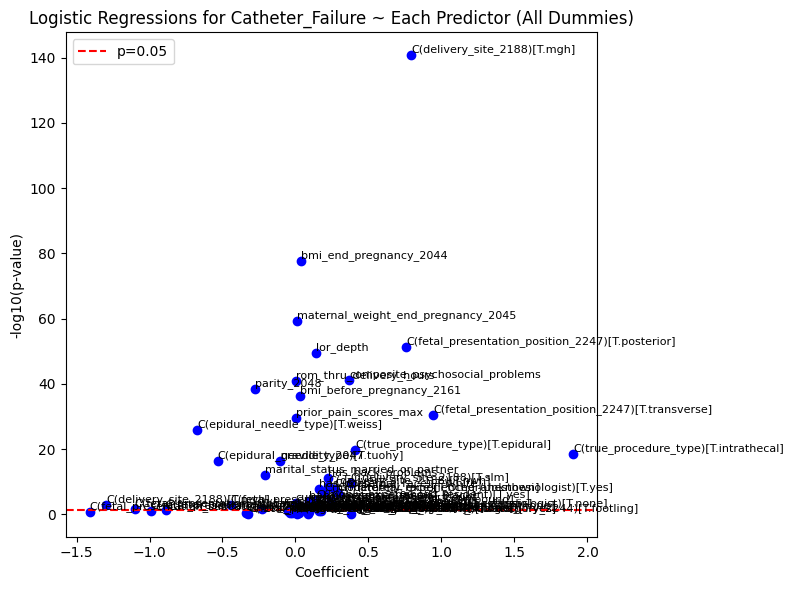

In [124]:

# Create plot: coefficient vs -log10(p-value)
fig, ax = plt.subplots(figsize=(8, 6))

offset = 1e-300  # so we don't take log10(0)
x_vals = results_df[results_df['pval'] < 0.9]['coef']
y_vals = -np.log10(results_df[results_df['pval'] < 0.9]['pval'] + offset)

sc = ax.scatter(x_vals, y_vals, color='blue')

# Annotate each point
for i, row in results_df[results_df['pval'] < 0.9].iterrows():
    ax.text(
        row['coef'],
        -np.log10(row['pval'] + offset),
        row['param_name'],  # or a cleaned-up version
        fontsize=8,
        ha='left',
        va='bottom'
    )

# Add a reference line for p=0.05
ax.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')

ax.set_xlabel('Coefficient')
ax.set_ylabel('-log10(p-value)')
ax.set_title(f'Logistic Regressions for Catheter_Failure ~ Each Predictor (All Dummies)')
ax.legend()

plt.tight_layout()
plt.show()


# Logistic Regression Model

In [ ]:
# Filter the DataFrame to include only neuraxial catheter (ie, epidural + CSE + intrathecal) or epidural-only catheter procedures
neuraxial_catheter_df = df[df['is_neuraxial_catheter'] == 1]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# Load the dataset
data = neuraxial_catheter_df

# Drop columns with more than 80% missing values
threshold = len(data) * 0.5
data_cleaned = data.dropna(thresh=threshold, axis=1)

# Drop rows where target variable is missing
data_cleaned = data_cleaned.dropna(subset=["failed_catheter"])

# Separate features and target variable
X = data_cleaned.drop(columns=["failed_catheter", "best_timestamp"], errors='ignore')
y = data_cleaned["failed_catheter"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train logistic regression with class weights
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', n_jobs=1)
logistic_model.fit(X_train_preprocessed, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test_preprocessed)
y_pred_prob = logistic_model.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate the model
evaluation_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_prob),
    "classification_report": classification_report(y_test, y_pred)
}

# Print evaluation metrics
print("Model Evaluation:")
for metric, value in evaluation_metrics.items():
    if metric == "classification_report":
        print("\nClassification Report:\n", value)
    else:
        print(f"{metric.capitalize()}: {value:.4f}")
